# Import and mount Drive

In [0]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import copy
import keras
from keras import models, layers
from keras.utils import to_categorical
from keras.models import load_model
from keras.layers import LSTM, Bidirectional, SimpleRNN, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn import metrics

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load data from files

In [0]:
path ="/content/drive/My Drive/Colab Notebooks/ML/"
!ls /content/drive/My\ Drive/Colab\ Notebooks/ML/conll_data

test.txt  train.txt  valid.txt


# Read GloVe embeddings
Download the GloVe embeddings 6B from https://nlp.stanford.edu/projects/glove/ and keep the 100d vectors.
Write a function that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embeddings.

In [0]:
embeddings_dict = {}
with open(path+"glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], "float32")
        embeddings_dict[word] = vector

print('Found %s word vectors' %len(embeddings_dict))

Found 400000 word vectors


In [0]:
next(iter(embeddings_dict))
embeddings_dict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

# Cosine similarity
Using a cosine similarity, compute the 5 closest words to the words table, france, and sweden.



In [0]:
def cos_sim(a, b, embeddings_dict): 
    return np.dot(embeddings_dict[a], embeddings_dict[b])/(np.linalg.norm(embeddings_dict[a])*np.linalg.norm(embeddings_dict[b])) 

In [0]:
# argsort och få index 
# argpartition
#TODO: write this function and compute 5 closest words.... 
#for word in embeddings_dict.keys(): 
similarities = np.zeros((3,5))
words = np.chararray((3,5), itemsize=20)
for w in embeddings_dict.keys():
    for idx, word in enumerate(['table', 'france', 'sweden']): # add the other two word in list 

        temp_sim = cos_sim(word, w, embeddings_dict)
        if temp_sim > np.min(similarities[idx,:]) and temp_sim < 1-1e-4:        # last part to avoid the word it self
            i = np.argmin(similarities[idx,:])
            similarities[idx, i] = temp_sim
            words[idx, i] = w

In [0]:
#get five best on index and find in word list 
print('Five closest words are: ', words)

Five closest words are:  [[b'tables' b'side' b'room' b'bottom' b'place']
 [b'french' b'paris' b'belgium' b'spain' b'britain']
 [b'netherlands' b'austria' b'denmark' b'finland' b'norway']]


#Reading the Corpus and Building Indices
You will read the corpus with programs available from https://github.com/pnugues/edan95. These programs will enable you to load the files in the form of a list of dictionaries.

1. Write a function that for each sentence returns the x and y lists of symbols consisting of words and NER tags.
2. Apply this function to your datasets so that you create X and Y lists of lists consisting of words and NER tags
3. Create a vocabulary of all the words observed in the training set and the words in GloVe.
4. Create indices and inverted indices for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.


In [0]:
with open(path+'conll_data/train.txt') as f:
    train_data = list(f)
with open(path+'conll_data/test.txt') as f:
    test_data = list(f)
with open(path+'conll_data/valid.txt') as f:
    val_data = list(f)

1. Extract word (x) and NER tags (y) from data


In [0]:
def entity_extractor(sentence):
  x = []
  y = []
  for word in sentence: 
    word_info = word.split()
    if len(word_info) > 0:
      x.append(word_info[0].lower())
      y.append(word_info[3])
  return x,y

2. create X, Y

In [0]:
def extract_features(data):
    X = []
    Y = []
    sentence = []
    for line in data:
        if len(line) > 1:
            sentence.append(line)
        else:
            x, y = entity_extractor(sentence)
            X.append(x)
            Y.append(y)
            sentence = []

    # If no blank line at EOF
    if len(sentence) > 0:
        x, y = entity_extractor(sentence)
        X.append(x)
        Y.append(y)
        sentence = []
    
    return X, Y

In [0]:
X_train, Y_train = extract_features(train_data)
X_val, Y_val = extract_features(val_data)
X_test, Y_test = extract_features(test_data)

# Corresponds to Pierres example
print(X_train[1])
print(Y_train[1])
print(len(X_train))
print(X_test[1])
print(Y_test[1])
print(len(X_test))

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
14987
['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']
3684


3. Create a vocabulary of all the words observed in the training set and the words in GloVe.


In [0]:
vocabulary = {}
vocabulary_NE = {}

for sentence in X_train:
    for word in sentence:
        vocabulary[word] = 0 

for word in embeddings_dict.keys():
        vocabulary[word] = 0 

for sentence in Y_train: 
    for NE in sentence: 
        vocabulary_NE[NE] = 0

In [0]:
# We should find 402,595 different words. And we do
len(vocabulary)

402595

4. Create indices and inverted indices for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words.


In [0]:
for idx, word in enumerate(vocabulary):
    vocabulary[word] = idx + 2

for idx, NE in enumerate(vocabulary_NE): 
    vocabulary_NE[NE] = idx + 2

#Building the Embedding Matrix

1. Create a matrix of dimensions (M, N), where M, will the size of the vocabulary: The unique words in the training set and the words in GloVe, and N, the dimension of the embeddings. The padding symbol and the unknown word symbol will be part of the vocabulary.
The shape of your matrix should be: (402597, 100). Initialize it with random values.

2. Fill the matrix with the GloVe embeddings. You will use the indices from the previous section.


In [0]:
max_words = len(vocabulary) + 2
embedding_dim = 100 
embedding_matrix = np.random.rand(max_words, embedding_dim) * 2 - 1 # U[-1,1]

for word, i in vocabulary.items():
    if i < max_words: 
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector

np.shape(embedding_matrix)

(402597, 100)

#Creating the X and Y Sequences
You will now create the input and output sequences with numerical indices

1. Convert the X and Y lists of symbols in lists of numbers using the indices you created.
2. Pad the sentences using the pad_sequences function.
3. Do the same for the development set.

In [0]:
def symbol_to_indices(M, vocabulary, maxlen):
    M_indices = copy.deepcopy(M)
    for i, sentence in enumerate(M_indices): 
        for j, word in enumerate(sentence): 
            try: 
                M_indices[i][j] = vocabulary[word]
            except: 
                M_indices[i][j] = 1
    return(pad_sequences(M_indices, maxlen=maxlen))

In [0]:
# Convert all symbols to indices
nbr_classes = len(vocabulary_NE)

maxlen = 150
X_train_pad = symbol_to_indices(X_train, vocabulary, maxlen)
X_val_pad = symbol_to_indices(X_val, vocabulary, maxlen)
X_test_pad = symbol_to_indices(X_test, vocabulary, maxlen)
Y_train_pad = symbol_to_indices(Y_train, vocabulary_NE, maxlen)
Y_val_pad = symbol_to_indices(Y_val, vocabulary_NE, maxlen)
Y_test_pad = symbol_to_indices(Y_test, vocabulary_NE, maxlen)

Y_train_pad = to_categorical(Y_train_pad, num_classes = nbr_classes + 2)
Y_val_pad = to_categorical(Y_val_pad, num_classes = nbr_classes + 2)
Y_test_pad = to_categorical(Y_test_pad, num_classes = nbr_classes + 2)

# slutet på pierres andra, vi har andra siffor men gör inget (samma antal nollskillda)
# ... 0 142143 307143 161836  91321 363368  83766  85852 218260    936
print(X_train_pad[1])
print(Y_train_pad[1])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  4  5
  6  7  8  9 10 11]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


#Building a Simple Recurrent Neural Network
1. Create a simple recurrent network and train a model with the train set. As layers, you will use Embedding, SimpleRNN, and Dense.


In [0]:
model = models.Sequential()

model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen, mask_zero = True)) #, input_length=2 * W_SIZE + 1))   
if embedding_matrix is not None:
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = True

model.add(SimpleRNN(embedding_dim, return_sequences=True))
model.add(layers.Dense(nbr_classes + 2, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 150, 100)          20100     
_________________________________________________________________
dense_1 (Dense)              (None, 150, 11)           1111      
Total params: 40,280,911
Trainable params: 40,280,911
Non-trainable params: 0
_________________________________________________________________




2. Compile and fit your network. You will report the training and validation losses and accuracies and comment on the possible overfit.


In [0]:
# 31s (25s hemma) per epoch (bs=128) on google gpu, acc~0.96 for both after 5 epochs
# 73s per epoch (bs=128) on google tpu, tpu better for big batches and highdimensional data
# 85s per epoch (bs=128) on my cpu
history = model.fit(X_train_pad, Y_train_pad, epochs=5, batch_size=128,
                    validation_data = (X_val_pad, Y_val_pad))



Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 32s 2ms/step - loss: 0.4161 - acc: 0.8867 - val_loss: 0.2542 - val_acc: 0.9347
Epoch 2/5
14987/14987 [==============================] - 30s 2ms/step - loss: 0.2046 - acc: 0.9423 - val_loss: 0.1942 - val_acc: 0.9471
Epoch 3/5
14987/14987 [==============================] - 30s 2ms/step - loss: 0.1573 - acc: 0.9541 - val_loss: 0.1909 - val_acc: 0.9441
Epoch 4/5
14987/14987 [==============================] - 31s 2ms/step - loss: 0.1331 - acc: 0.9605 - val_loss: 0.1577 - val_acc: 0.9572
Epoch 5/5
14987/14987 [==============================] - 31s 2ms/step - loss: 0.1155 - acc: 0.9656 - val_loss: 0.1549 - val_acc: 0.9586


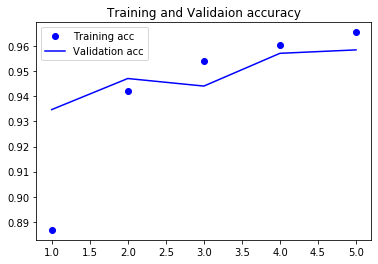

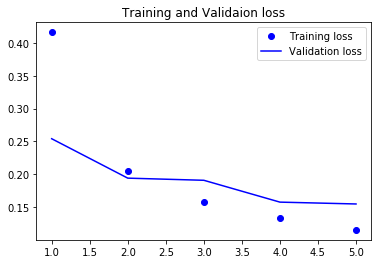

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()


3. Apply your network to the test set and report the accuracy you obtained. You will use the evaluate method.

In [0]:
test_loss, test_acc = model.evaluate(X_test_pad, Y_test_pad)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

3684/3684 [==============================] - 11s 3ms/step
Loss: 0.1942324795063492
Accuracy: 0.9412656568160663


This following part might be unnecessary

#Evaluating your System
You will use the official script to evaluate the performance of your system

1. Use the predict method to predict the tags of the whole test set


In [0]:
def predict_NER(model, outfile):

    predictions = model.predict(X_test_pad)  # , int(np.ceil(len(test_labels) / batch_size)))
    preds = np.argmax(predictions, axis=2)
    trues = np.argmax(Y_test_pad, axis=2)

    preds_short = [preds[i, -len(X_test[i]) : ] for i in range(len(preds))]
    trues_short = [trues[i, -len(X_test[i]) : ] for i in range(len(preds))]
    preds_concat = np.concatenate(preds_short)
    y_test_concat = np.concatenate(trues_short)

    tag_pred = []
    tag_true = []

    tmp_voc = {}
    for i in vocabulary_NE.items():
        tmp_voc[i[1]] = i[0]

    for yp in preds_concat: 
        tag_pred.append(tmp_voc[yp])

    for yt in y_test_concat: 
        tag_true.append(tmp_voc[yt])

    X_test_vec = np.concatenate(X_test)

    result = np.concatenate((np.array([X_test_vec]), np.array([tag_true]), np.array([tag_pred])), axis=0).T

    np.shape(result)

    with open(path + outfile, 'wb') as f:
        for line in result:
            for word in line: 
                f.write((word+ ' ').encode())
            f.write(('\n').encode())



2. Write your results in a file, where the two last columns will be the hand-annotated tag and the predicted tag. The fields must be separated by a space.



In [0]:
predict_NER(model, 'outfile.txt')

3. Apply conlleval to your output. Report the F1 result.


In [0]:
# model
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile.txt

processed 46666 tokens with 5648 phrases; found: 5568 phrases; correct: 4024.
accuracy:  94.47%; precision:  72.27%; recall:  71.25%; FB1:  71.75
              LOC: precision:  76.40%; recall:  85.01%; FB1:  80.48  1856
             MISC: precision:  56.36%; recall:  57.41%; FB1:  56.88  715
              ORG: precision:  64.77%; recall:  60.20%; FB1:  62.40  1544
              PER: precision:  82.79%; recall:  74.40%; FB1:  78.37  1453


4. Try to improve your model by modifying some parameters, adding layers, adding Bidirectional and Dropout.


In [0]:
model_2 = models.Sequential()

model_2.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen, mask_zero = True)) #, input_length=2 * W_SIZE + 1))   
if embedding_matrix is not None:
    model_2.layers[0].set_weights([embedding_matrix])
    model_2.layers[0].trainable = True

# Bidirectional: dubbelt så många parametrar i lagret så tränar klart långsammare men ger bättre resultat
model_2.add(Bidirectional(SimpleRNN(embedding_dim, return_sequences=True)))
model_2.add(layers.Dense(nbr_classes + 2, activation='softmax'))

model_2.summary()
# ADAM?
model_2.compile(loss='categorical_crossentropy',
                   optimizer='Nadam',
                   metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 200)          40200     
_________________________________________________________________
dense_2 (Dense)              (None, 150, 11)           2211      
Total params: 40,302,111
Trainable params: 40,302,111
Non-trainable params: 0
_________________________________________________________________


In [0]:
history_2 = model_2.fit(X_train_pad, Y_train_pad, epochs=5, batch_size=128,
                    validation_data = (X_val_pad, Y_val_pad))

Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 54s 4ms/step - loss: 0.3375 - acc: 0.9069 - val_loss: 0.1719 - val_acc: 0.9532
Epoch 2/5
14987/14987 [==============================] - 52s 3ms/step - loss: 0.1237 - acc: 0.9652 - val_loss: 0.1395 - val_acc: 0.9619
Epoch 3/5
14987/14987 [==============================] - 52s 3ms/step - loss: 0.0737 - acc: 0.9796 - val_loss: 0.1286 - val_acc: 0.9660
Epoch 4/5
14987/14987 [==============================] - 52s 3ms/step - loss: 0.0472 - acc: 0.9872 - val_loss: 0.1158 - val_acc: 0.9701
Epoch 5/5
14987/14987 [==============================] - 52s 3ms/step - loss: 0.0302 - acc: 0.9920 - val_loss: 0.1254 - val_acc: 0.9708


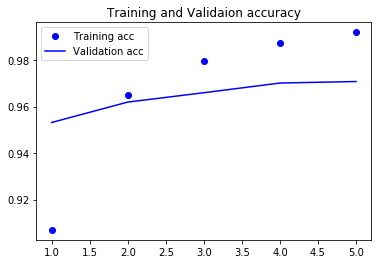

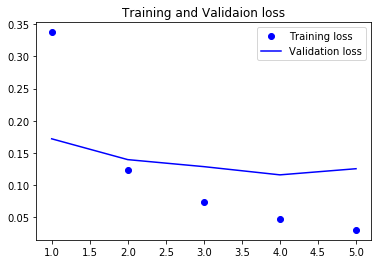

In [0]:
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = model_2.evaluate(X_test_pad, Y_test_pad)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

3684/3684 [==============================] - 18s 5ms/step
Loss: 0.17494365099279552
Accuracy: 0.95658992789079


5. Evaluate your network again

In [0]:
predict_NER(model_2, 'outfile_2.txt')
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile_2.txt

processed 46666 tokens with 5648 phrases; found: 5532 phrases; correct: 4440.
accuracy:  95.83%; precision:  80.26%; recall:  78.61%; FB1:  79.43
              LOC: precision:  85.18%; recall:  88.55%; FB1:  86.83  1734
             MISC: precision:  71.04%; recall:  63.25%; FB1:  66.92  625
              ORG: precision:  75.65%; recall:  68.27%; FB1:  71.77  1499
              PER: precision:  82.74%; recall:  85.65%; FB1:  84.17  1674


#Building a LSTM Network
1. Create a simple LSTM network and train a model with the train set. As layers, you will use Embedding, LSTM, and Dense.


In [0]:
model_LSTM = models.Sequential()

model_LSTM.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen, mask_zero = True)) #, input_length=2 * W_SIZE + 1))   
if embedding_matrix is not None:
    model_LSTM.layers[0].set_weights([embedding_matrix])
    model_LSTM.layers[0].trainable = True

# model.add(flatten())
# ta bort relu, tanh är standard för rnn/lstm av symetriskäl (for real)
model_LSTM.add(LSTM(embedding_dim, return_sequences=True))
model_LSTM.add(layers.Dense(nbr_classes + 2, activation='softmax'))

model_LSTM.summary()
model_LSTM.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 100)          80400     
_________________________________________________________________
dense_3 (Dense)              (None, 150, 11)           1111      
Total params: 40,341,211
Trainable params: 40,341,211
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 55s med tanh, va=0.9582
# 55s med relu, va=0.9582
history_LSTM = model_LSTM.fit(X_train_pad, Y_train_pad, epochs=5, batch_size=128,
                    validation_data = (X_val_pad, Y_val_pad))

Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 61s 4ms/step - loss: 0.5499 - acc: 0.8589 - val_loss: 0.3232 - val_acc: 0.9156
Epoch 2/5
14987/14987 [==============================] - 60s 4ms/step - loss: 0.2336 - acc: 0.9364 - val_loss: 0.2118 - val_acc: 0.9454
Epoch 3/5
14987/14987 [==============================] - 59s 4ms/step - loss: 0.1643 - acc: 0.9529 - val_loss: 0.1649 - val_acc: 0.9563
Epoch 4/5
14987/14987 [==============================] - 60s 4ms/step - loss: 0.1334 - acc: 0.9609 - val_loss: 0.1562 - val_acc: 0.9583
Epoch 5/5
14987/14987 [==============================] - 59s 4ms/step - loss: 0.1142 - acc: 0.9660 - val_loss: 0.1507 - val_acc: 0.9564


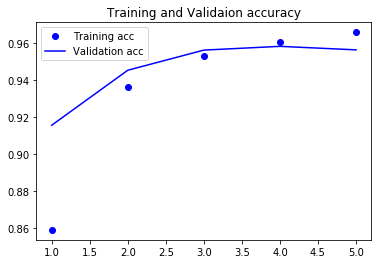

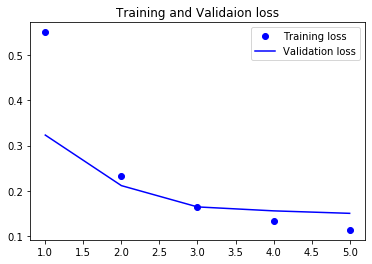

In [0]:
acc = history_LSTM.history['acc']
val_acc = history_LSTM.history['val_acc']
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [0]:
# acc=0.9436 med tanh, but this makes more sense
# acc=0.9466 med relu
test_loss, test_acc = model_LSTM.evaluate(X_test_pad, Y_test_pad)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

3684/3684 [==============================] - 17s 5ms/step
Loss: 0.19068496828811823
Accuracy: 0.9407527588477741


2. Apply conlleval to your output. Report the F1 result.


In [0]:
predict_NER(model_LSTM, 'outfile_LSTM.txt')
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile_LSTM.txt

processed 46666 tokens with 5648 phrases; found: 6110 phrases; correct: 4230.
accuracy:  94.22%; precision:  69.23%; recall:  74.89%; FB1:  71.95
              LOC: precision:  78.58%; recall:  84.23%; FB1:  81.31  1788
             MISC: precision:  41.22%; recall:  51.85%; FB1:  45.93  883
              ORG: precision:  60.43%; recall:  67.49%; FB1:  63.77  1855
              PER: precision:  84.60%; recall:  82.87%; FB1:  83.72  1584


3. Try to improve your model by modifying some parameters, adding layers, adding Bidirectional, Dropout, possibly mixing SimpleRNN.


In [0]:
# Going hardcore 
NINJA_MODEL = models.Sequential()

NINJA_MODEL.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen, mask_zero = True)) #, input_length=2 * W_SIZE + 1))   
if embedding_matrix is not None:
    NINJA_MODEL.layers[0].set_weights([embedding_matrix])
    NINJA_MODEL.layers[0].trainable = True

# model.add(flatten())
NINJA_MODEL.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))
NINJA_MODEL.add(Dropout(0.5))
NINJA_MODEL.add(Bidirectional(SimpleRNN(embedding_dim, return_sequences=True)))
NINJA_MODEL.add(Dropout(0.5))
NINJA_MODEL.add(Bidirectional(LSTM(embedding_dim, return_sequences=True)))
NINJA_MODEL.add(Dropout(0.5))
NINJA_MODEL.add(layers.Dense(nbr_classes + 2, activation='softmax'))

NINJA_MODEL.summary()
NINJA_MODEL.compile(loss='categorical_crossentropy',
                   optimizer='Nadam',
                   metrics=['accuracy'])

### andra möjliga lager
# model.add(Bidirectional(SimpleRNN(100, return_sequences=True)))
# model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(Dense(NB_CLASSES + 2, activation='softmax'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 100)          40259700  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 200)          160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 200)          60200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 150, 200)          240800    
____

In [0]:
# 257s per epoch
history_NM = NINJA_MODEL.fit(X_train_pad, Y_train_pad, epochs=5, batch_size=128,
                    validation_data = (X_val_pad, Y_val_pad))
# checkpoints 
# early stopping 

Train on 14987 samples, validate on 3466 samples
Epoch 1/5
14987/14987 [==============================] - 268s 18ms/step - loss: 0.4600 - acc: 0.8806 - val_loss: 0.1891 - val_acc: 0.9501
Epoch 2/5
14987/14987 [==============================] - 264s 18ms/step - loss: 0.1499 - acc: 0.9571 - val_loss: 0.1257 - val_acc: 0.9656
Epoch 3/5
14987/14987 [==============================] - 268s 18ms/step - loss: 0.0961 - acc: 0.9720 - val_loss: 0.1411 - val_acc: 0.9668
Epoch 4/5
14987/14987 [==============================] - 262s 17ms/step - loss: 0.0673 - acc: 0.9803 - val_loss: 0.1135 - val_acc: 0.9730
Epoch 5/5
14987/14987 [==============================] - 262s 17ms/step - loss: 0.0492 - acc: 0.9856 - val_loss: 0.1142 - val_acc: 0.9746


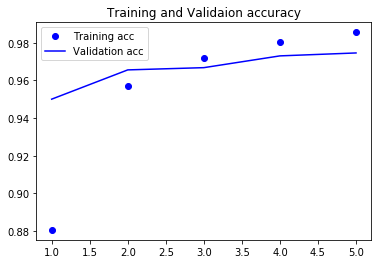

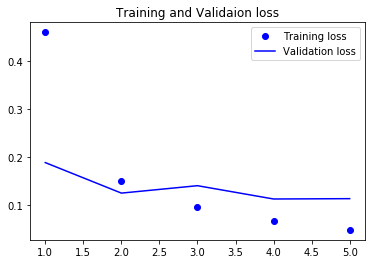

In [0]:
acc = history_NM.history['acc']
val_acc = history_NM.history['val_acc']
loss = history_NM.history['loss']
val_loss = history_NM.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validaion loss')
plt.legend()

plt.show()

In [0]:
test_loss, test_acc = NINJA_MODEL.evaluate(X_test_pad, Y_test_pad)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

3684/3684 [==============================] - 85s 23ms/step
Loss: 0.16239155347162734
Accuracy: 0.9613544179872892


In [0]:
predict_NER(NINJA_MODEL, 'outfile_NINJA.txt')
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile_NINJA.txt

processed 46666 tokens with 5648 phrases; found: 5556 phrases; correct: 4618.
accuracy:  96.25%; precision:  83.12%; recall:  81.76%; FB1:  82.43
              LOC: precision:  84.97%; recall:  90.17%; FB1:  87.49  1770
             MISC: precision:  66.94%; recall:  68.66%; FB1:  67.79  720
              ORG: precision:  80.34%; recall:  74.05%; FB1:  77.07  1531
              PER: precision:  91.34%; recall:  86.70%; FB1:  88.96  1535


In [0]:
# SAVE ALL THE MODELS
import pickle

with open(path + 'model.p', 'wb') as f:
    pickle.dump(model, f)

with open(path + 'model_2.p', 'wb') as f:
    pickle.dump(model_2, f)

with open(path + 'model_LSTM.p', 'wb') as f:
    pickle.dump(model_LSTM, f)

with open(path + 'NINJA_MODEL.p', 'wb') as f:
    pickle.dump(NINJA_MODEL, f)

# Saving training histories as well
with open(path + 'h.p', 'wb') as f:
    pickle.dump(history, f)

with open(path + 'h_2.p', 'wb') as f:
    pickle.dump(history_2, f)

with open(path + 'h_LSTM.p', 'wb') as f:
    pickle.dump(history_LSTM, f)

with open(path + 'h_NINJA_MODEL.p', 'wb') as f:
    pickle.dump(history_NM, f)

4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass

In [0]:
# Open models
import pickle

with open(path + 'model.p', 'rb') as f:
    model = pickle.load(f)

with open(path + 'model_2.p', 'rb') as f:
    model_2 = pickle.load(f)

with open(path + 'model_LSTM.p', 'rb') as f:
    model_LSTM = pickle.load(f)

with open(path + 'NINJA_MODEL.p', 'rb') as f:
    NINJA_MODEL = pickle.load(f)

# Opening training histories as well
with open(path + 'h.p', 'rb') as f:
    history = pickle.load(f)

with open(path + 'h_2.p', 'rb') as f:
    history_2 = pickle.load(f)

with open(path + 'h_LSTM.p', 'rb') as f:
    history_LSTM = pickle.load(f)

with open(path + 'h_NINJA_MODEL.p', 'rb') as f:
    history_NM = pickle.load(f)


All F1-scores

In [0]:
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile.txt
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile_2.txt
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile_LSTM.txt
!perl /content/drive/My\ Drive/Colab\ Notebooks/ML/conlleval  < /content/drive/My\ Drive/Colab\ Notebooks/ML/outfile_NINJA.txt

processed 46666 tokens with 5648 phrases; found: 5568 phrases; correct: 4024.
accuracy:  94.47%; precision:  72.27%; recall:  71.25%; FB1:  71.75
              LOC: precision:  76.40%; recall:  85.01%; FB1:  80.48  1856
             MISC: precision:  56.36%; recall:  57.41%; FB1:  56.88  715
              ORG: precision:  64.77%; recall:  60.20%; FB1:  62.40  1544
              PER: precision:  82.79%; recall:  74.40%; FB1:  78.37  1453
processed 46666 tokens with 5648 phrases; found: 5532 phrases; correct: 4440.
accuracy:  95.83%; precision:  80.26%; recall:  78.61%; FB1:  79.43
              LOC: precision:  85.18%; recall:  88.55%; FB1:  86.83  1734
             MISC: precision:  71.04%; recall:  63.25%; FB1:  66.92  625
              ORG: precision:  75.65%; recall:  68.27%; FB1:  71.77  1499
              PER: precision:  82.74%; recall:  85.65%; FB1:  84.17  1674
processed 46666 tokens with 5648 phrases; found: 6110 phrases; correct: 4230.
accuracy:  94.22%; precision:  69.23%; r

### F1 score

|Model  | F1 |
| :---  | :-------- |
|Initial|71.75 |
|Improved Bidirectional SimpleRNN|79.43|
|LSTM |71.95|
|improved LSTM + RNN|82.43|